In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler

## Dataset

In [21]:
df = pd.read_csv('datasets/btc_3m.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df

,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13666.11,13680.00,6.303815
2018-01-01 05:33:00,13679.98,13679.98,13554.44,13568.00,33.709206
2018-01-01 05:36:00,13568.00,13575.00,13501.01,13575.00,29.645987
2018-01-01 05:39:00,13539.99,13575.00,13400.01,13515.26,30.696039
2018-01-01 05:42:00,13515.26,13568.66,13473.47,13556.15,23.260966
...,...,...,...,...,...
2022-01-31 05:18:00,37919.05,37919.05,37876.94,37891.30,30.717900
2022-01-31 05:21:00,37891.30,37946.56,37870.00,37918.80,28.369420
2022-01-31 05:24:00,37918.79,37948.79,37888.88,37898.01,22.346010


In [22]:
# Filtering the dataset

start_date = '2018-01-01'
end_date = '2019-01-01'
filtered_df = df.loc[start_date:end_date]
print(filtered_df.shape)
filtered_df.iloc[[0,-1],:]

(174247, 5)


,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13666.11,13680.00,6.303815
2019-01-01 23:57:00,3678.00,3680.33,3675.25,3675.26,19.906142


In [23]:
# Adding indicators

def calculate_rsi(data, period=14):
    close_diff = data['close'].diff(1)
    gain = close_diff.where(close_diff > 0, 0)
    loss = -close_diff.where(close_diff < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

filtered_df['RSI'] = calculate_rsi(filtered_df)

# Calculate Moving Average Convergence Divergence (MACD) and Signal Line
def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    exp12 = data['close'].ewm(span=fast_period, adjust=False).mean()
    exp26 = data['close'].ewm(span=slow_period, adjust=False).mean()

    macd = exp12 - exp26
    signal = macd.ewm(span=signal_period, adjust=False).mean()

    return macd, signal

filtered_df['MACD'], filtered_df['signal_line'] = calculate_macd(filtered_df)
filtered_df['MACD_signal_diff'] = filtered_df['MACD'] - filtered_df['signal_line']
filtered_df.drop(columns=['MACD','signal_line'],inplace=True)

# Calculate Exponential Moving Average (EMA)
filtered_df['EMA'] = filtered_df['close'].ewm(span=14, adjust=False).mean()

# Calculate Moving Averages (50 and 100)
filtered_df['MA_50'] = filtered_df['close'].rolling(window=50).mean()
filtered_df['MA_100'] = filtered_df['close'].rolling(window=100).mean()

# Calculate On Balance Volume (OBV)
filtered_df['OBV'] = filtered_df['volume'].cumsum()

# Dropping rows with null values
filtered_df.dropna(inplace=True)

# Print the updated DataFrame
print(filtered_df.shape)
filtered_df.head()

(174148, 11)


C:\Users\sanya\AppData\Local\Temp\ipykernel_1772\2212376076.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['RSI'] = calculate_rsi(filtered_df)
C:\Users\sanya\AppData\Local\Temp\ipykernel_1772\2212376076.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['MACD'], filtered_df['signal_line'] = calculate_macd(filtered_df)
C:\Users\sanya\AppData\Local\Temp\ipykernel_1772\2212376076.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,open,high,low,close,volume,RSI,MACD_signal_diff,EMA,MA_50,MA_100,OBV
datetime,,,,,,,,,,,
2018-01-01 10:27:00,13565.01,13623.29,13532.42,13601.01,46.215130,83.643678,16.877722,13506.154842,13429.2028,13443.1829,2017.012136
2018-01-01 10:30:00,13615.20,13677.83,13572.10,13636.37,48.997021,84.759188,19.047744,13523.516863,13436.5518,13442.7466,2066.009157
2018-01-01 10:33:00,13648.24,13671.43,13610.02,13640.00,31.461851,82.956792,19.406885,13539.047948,13443.4608,13443.4666,2097.471008
2018-01-01 10:36:00,13640.01,13667.65,13600.00,13640.53,45.699336,80.691694,18.370107,13552.578888,13451.7568,13444.1219,2143.170344
2018-01-01 10:39:00,13640.53,13663.99,13552.02,13552.03,33.411619,64.585375,10.789188,13552.505703,13458.2754,13444.4896,2176.581963


In [24]:
# Adding the change in close price column

filtered_df['close_change'] = filtered_df['close'].shift(-1) - filtered_df['close']
filtered_df.head()

C:\Users\sanya\AppData\Local\Temp\ipykernel_1772\1043046407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close_change'] = filtered_df['close'].shift(-1) - filtered_df['close']


,open,high,low,close,volume,RSI,MACD_signal_diff,EMA,MA_50,MA_100,OBV,close_change
datetime,,,,,,,,,,,,
2018-01-01 10:27:00,13565.01,13623.29,13532.42,13601.01,46.215130,83.643678,16.877722,13506.154842,13429.2028,13443.1829,2017.012136,35.36
2018-01-01 10:30:00,13615.20,13677.83,13572.10,13636.37,48.997021,84.759188,19.047744,13523.516863,13436.5518,13442.7466,2066.009157,3.63
2018-01-01 10:33:00,13648.24,13671.43,13610.02,13640.00,31.461851,82.956792,19.406885,13539.047948,13443.4608,13443.4666,2097.471008,0.53
2018-01-01 10:36:00,13640.01,13667.65,13600.00,13640.53,45.699336,80.691694,18.370107,13552.578888,13451.7568,13444.1219,2143.170344,-88.50
2018-01-01 10:39:00,13640.53,13663.99,13552.02,13552.03,33.411619,64.585375,10.789188,13552.505703,13458.2754,13444.4896,2176.581963,75.11


### Train test split and preparing data for LSTM

In [6]:
# Train test split
split_ratio = 0.8
split_index = int(split_ratio * len(filtered_df))

train_data = filtered_df[:split_index]
test_data = filtered_df[split_index:]
print(f"Train shape:{train_data.shape}")
print(f"test shape:{test_data.shape}")

Train shape:(139318, 12)
test shape:(34830, 12)


In [7]:
# Scaling the data
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [8]:
# Making sequences
def create_sequences(data, sequence_length=14):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data.iloc[i-sequence_length: i])
        y.append(data.iloc[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
print(f"X_train shape:{X_train.shape}")
print(f"y_train shape:{y_train.shape}")

X_test, y_test = create_sequences(test_data)
print(f"X_test shape:{X_test.shape}")
print(f"y_test shape:{y_test.shape}")

X_train shape:(139304, 14, 12)
y_train shape:(139304, 12)
X_test shape:(34816, 14, 12)
y_test shape:(34816, 12)


## LSTM Model

In [9]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.activations import leaky_relu
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint

In [10]:
time_stamp = datetime.datetime.timestamp(datetime.datetime.now())

In [11]:
cp_path = f"models/BTC_LSTM_cp_{time_stamp}.h5"
cp_callback = ModelCheckpoint(cp_path
                              ,monitor="val_loss"
                              ,save_best_only=True
                              ,mode='min')

In [14]:
model = Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64))
model.add(Dense(12, activation="linear"))

model.compile(loss='mean_absolute_error',
              optimizer=Adam(),
              metrics=['mean_squared_error'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            19712     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 12)                780       
                                                                 
Total params: 53,516
Trainable params: 53,516
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=32, callbacks=[cp_callback])

Epoch 1/32
3483/3483 [==============================] - 29s 8ms/step - loss: 348108.6875 - mean_squared_error: 1897242296320.0000 - val_loss: 795733.5000 - val_mean_squared_error: 7553260453888.0000
Epoch 2/32
3483/3483 [==============================] - 26s 8ms/step - loss: 347956.8750 - mean_squared_error: 1897084485632.0000 - val_loss: 795582.6250 - val_mean_squared_error: 7552899219456.0000
Epoch 3/32
3483/3483 [==============================] - 26s 8ms/step - loss: 347805.9688 - mean_squared_error: 1896926806016.0000 - val_loss: 795430.9375 - val_mean_squared_error: 7552543227904.0000
Epoch 4/32
3483/3483 [==============================] - 26s 8ms/step - loss: 347655.4062 - mean_squared_error: 1896768077824.0000 - val_loss: 795280.6250 - val_mean_squared_error: 7552183042048.0000
Epoch 5/32
3483/3483 [==============================] - 26s 8ms/step - loss: 347504.0938 - mean_squared_error: 1896615116800.0000 - val_loss: 795128.6875 - val_mean_squared_error: 7551825477632.0000
Epoch

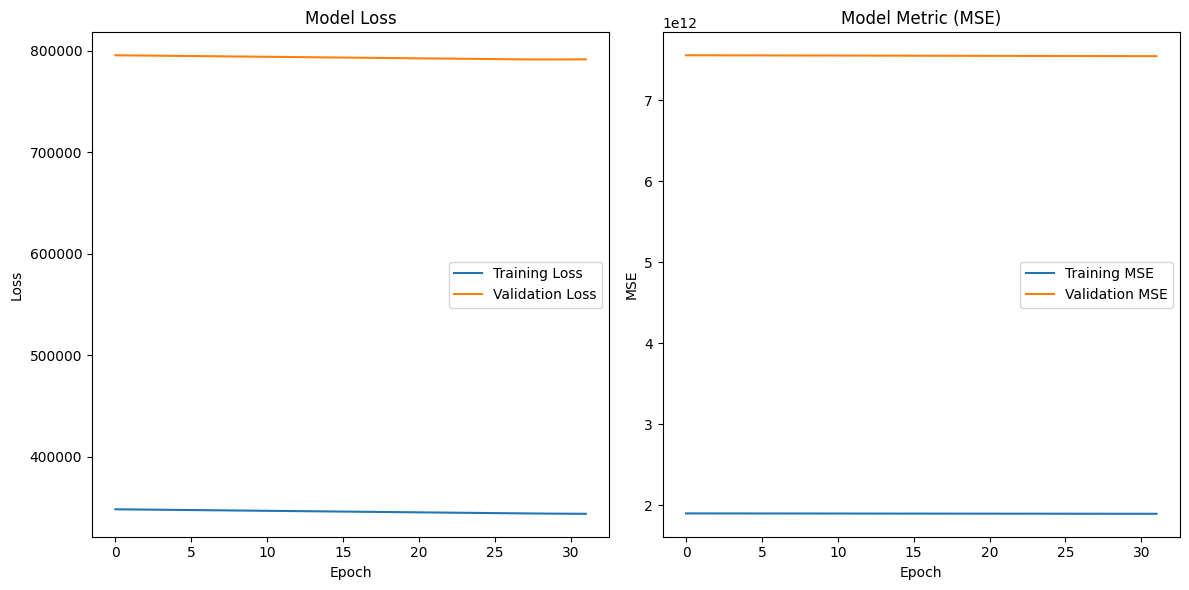

In [16]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation metrics (e.g., Mean Squared Error)
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Model Metric (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
model.save(f"models/BTC_LSTM_{time_stamp}.h5")

In [18]:
from keras.models import load_model
model = load_model(f'models/BTC_LSTM_cp_{time_stamp}.h5')

In [19]:
# Evaluateing the test loss

model.evaluate(X_test,y_test)

1088/1088 [==============================] - 4s 3ms/step - loss: nan - mean_squared_error: nan                    


[nan, nan]

In [ ]:
predictions = model.predict(X_test)

# Inverse transformation
predicted_values = scaler.inverse_transform(predictions)
original_values = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
plt.plot(predicted_values)
plt.plot(original_values)

## Trade simulation

In [ ]:
features = ["open"	,"high",	"low" ,"volume" , "rsi"]

In [ ]:
balance_usdt = 10000
balance_btc = 0
stop_loss = balance_btc*(0.002)

for i in range(df_3m.shape[0]):
    
    # get the date for the i th row
    date = df_3m.iloc[i]['datetime']

    # Get the data for the date
    data = df_3m[df_3m['datetime'] == date]

    # Get the feature vector for the date
    x = data.drop(columns=['datetime','close_Change'])
    print(x.as_numpy())
    # Predict the price using the model
    y_pred = model.predict(x)

    # difference between the predicted close and actual open
    open=data["open"].values[0]
    close_predicted=y_pred[0]
    diff = close_predicted-open

    # Compare the predicted class with the actual class
    if diff > 0 and balance_usdt>0:
        btc=(balance_usdt-0.0015*balance_usdt)/open
        stop_loss = balance_usdt*(0.002)
        balance_btc=btc
        balance_usdt=0
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [buying]')

    elif diff<0 and diff < (-stop_loss) and balance_btc>0:  # Changed this line
        usdt=balance_btc*open
        balance_usdt=usdt-(0.0015*usdt)
        balance_btc=0
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [selling]')
    else:
        print(f'{date} -> : usdt : {balance_usdt}   btc : {balance_btc}   [holding]')

    #if loop reached the end convert all btc to usd
    if i==df.shape[0]-1 and balance_usdt==0:
        usdt=balance_btc*open
        balance_usdt=usdt
        balance_btc=0
    #print the balance and btc
    
# Print the final balances after executing the trades
print(f"Final Balances: USDT {balance_usdt}, BTC {balance_btc}")